In [524]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
from scipy.signal import hilbert
import numpy as np
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter

DATA_LENGTH = 200
NUM_PULSES = 35

In [525]:
ruth_achilles_cuff_file_names = [
    "logs/trial_1_7_16/cuff_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/cuff_data_trial_1_run_5_ruth.txt"
]
ruth_achilles_hammer_file_names = [
    "logs/trial_1_7_16/hammer_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/hammer_data_trial_1_run_5_ruth.txt"    
]
rachel_achilles_cuff_file_names = [
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_1_rachel.txt", 
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_2_rachel.txt", 
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_3_rachel.txt",  
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_4_rachel.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_4_rachel copy.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_5_rachel.txt",
    "logs/trial_3_7_16_rachel/cuff_data_trial_3_run_6_rachel.txt"
]

rachel_achilles_hammer_file_names = [
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_1_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_2_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_3_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_4_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_4_rachel copy.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_5_rachel.txt", 
    "logs/trial_3_7_16_rachel/hammer_data_trial_3_run_6_rachel.txt"
]

chosen_folder_cuff = rachel_achilles_cuff_file_names
chosen_folder_hammer = rachel_achilles_hammer_file_names

cuff_dfs = []
hammer_dfs = []
for file_name in chosen_folder_cuff:
    cuff_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())
for file_name in chosen_folder_hammer:
    hammer_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())

In [526]:
################## Find the indicies of the minimum of each waveform ###############

cuff_indiv_waveform_minima_indicies = []
DATA_LENGTH = 200 # Defined in Arduino -- number of points sampled per pulse (pulse_and_read_cuff_v3.ino)

for cuff_df in cuff_dfs:
    this_cuff_indiv_waveform_minima_indicies = []
    for i in range(0, len(cuff_df), DATA_LENGTH):
        single_burst_cuff_waveform = list(cuff_df[:,1])[i: i+DATA_LENGTH]
        index_min = single_burst_cuff_waveform.index(min(single_burst_cuff_waveform))
        this_cuff_indiv_waveform_minima_indicies.append(index_min + i)
        
    cuff_indiv_waveform_minima_indicies.append(this_cuff_indiv_waveform_minima_indicies)

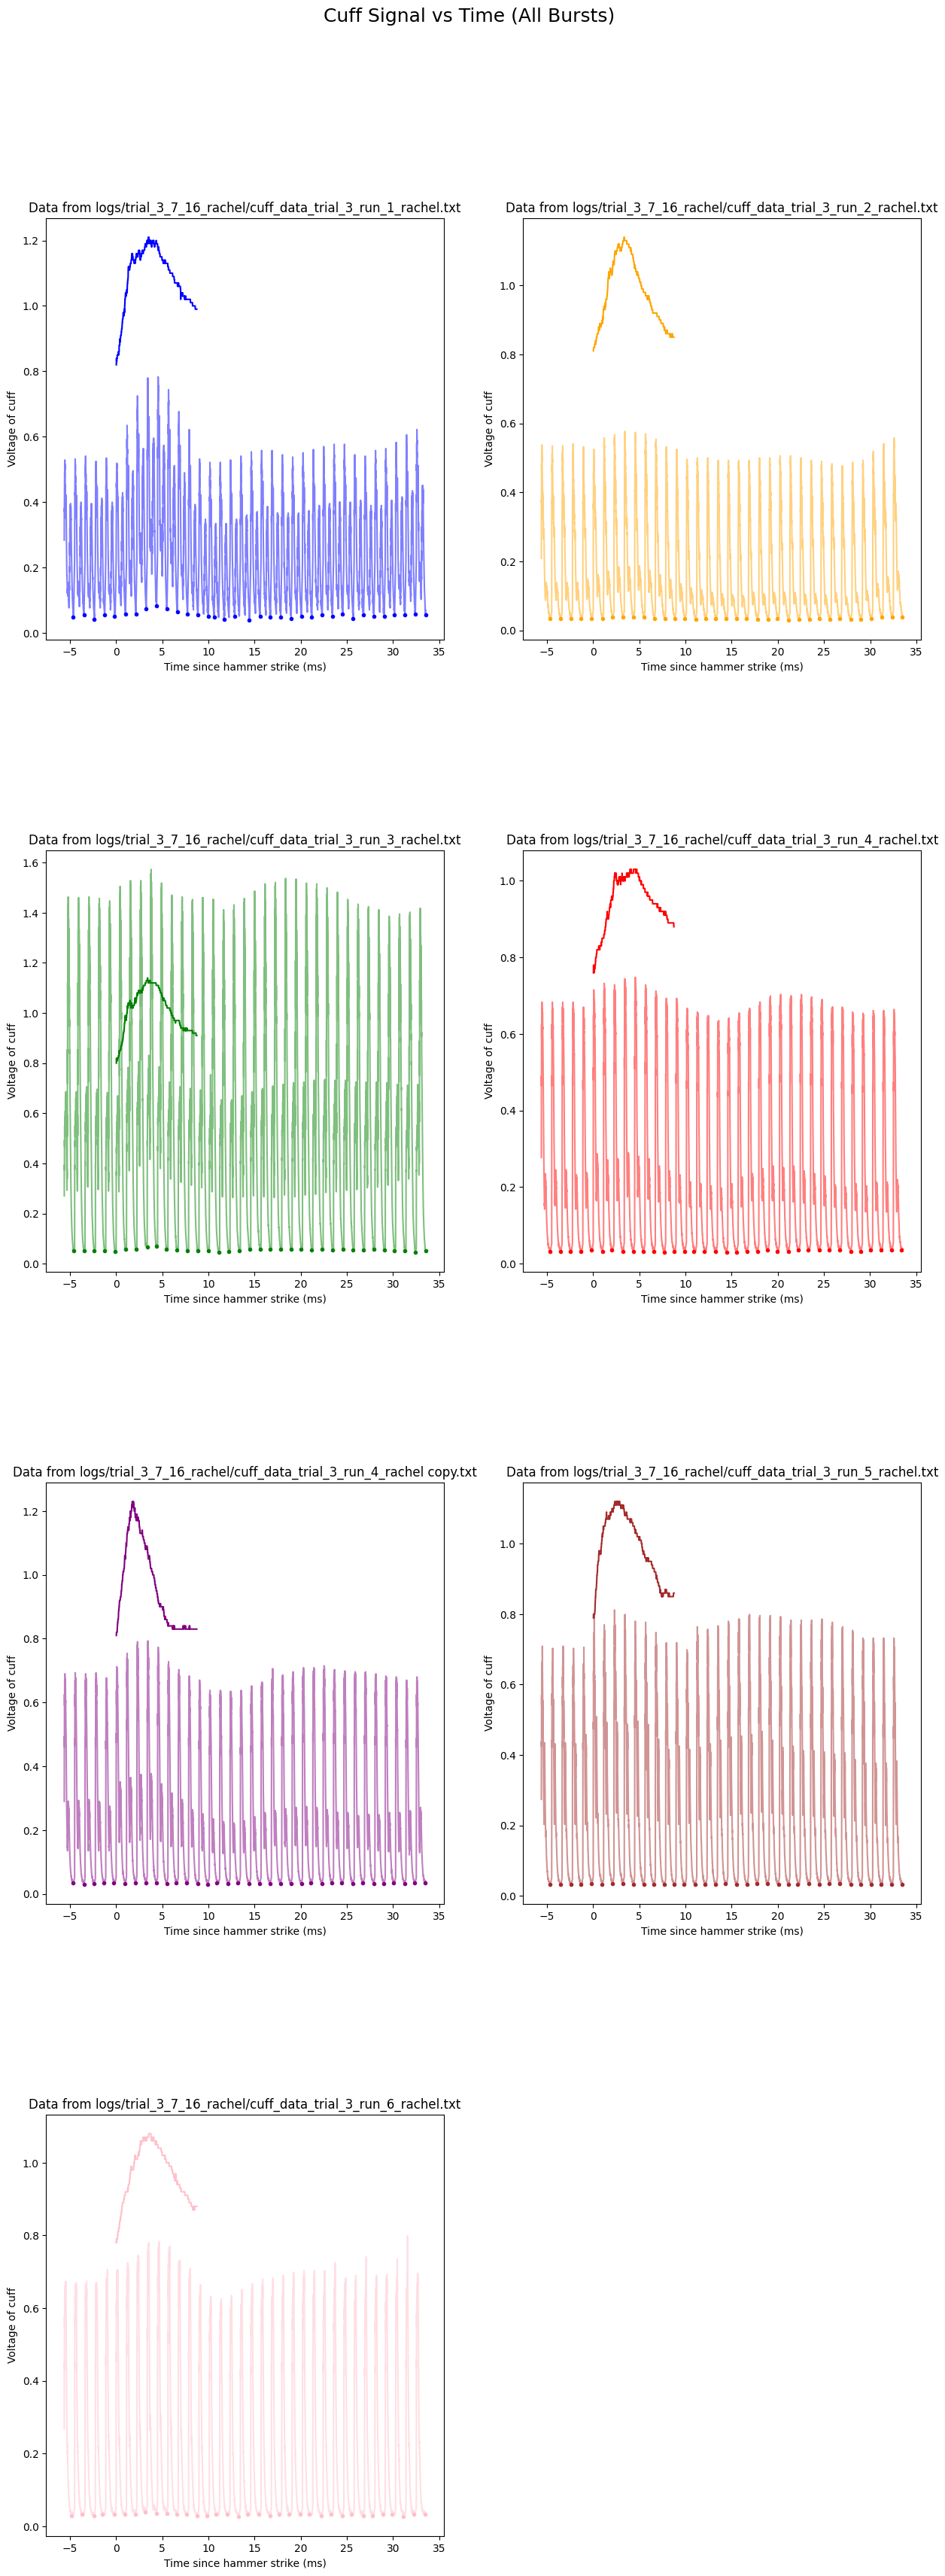

In [527]:
plt.figure(figsize=(15, 40))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Cuff Signal vs Time (All Bursts)", fontsize=18, y=0.95)

n = 0
overlay = False
ax_subp = None

color_array = ["blue", "orange", "green", "red", "purple", "brown", 
               "pink", "gray", "olive", "cyan", "turquoise", "magenta", "maroon", "tan"]

for n in range(len(cuff_dfs)):
    df_cuff = cuff_dfs[n]
    df_hammer = hammer_dfs[n]
    waveform_minima = cuff_indiv_waveform_minima_indicies[n]

    # add a new subplot iteratively
    if (not overlay): ax_subp = plt.subplot(4, 2, n+1)
    elif (ax_subp is None): ax_subp = plt.subplot(1, 1, 1)

    ax_subp.plot(df_cuff[:,0], df_cuff[:,1], c=color_array[n % len(cuff_dfs)], alpha = 0.5, label="Cuff")
    ax_subp.plot(df_hammer[:,0], df_hammer[:,1], c=color_array[n % len(cuff_dfs)], label="Hammer")
    for m in waveform_minima:  
        ax_subp.plot(df_cuff[:,0][m], df_cuff[:,1][m], c=color_array[n % len(cuff_dfs)], marker="o", markersize=3)


    # chart formatting
    if (not overlay): ax_subp.set_title("Data from " + str(chosen_folder_cuff[n]))
    ax_subp.set_xlabel("Time since hammer strike (ms)")
    ax_subp.set_ylabel("Voltage of cuff")

if (overlay): plt.legend(chosen_folder_cuff)
plt.show()

In [528]:
cuff_df_reshaped_by_burst = []
for cuff_df in cuff_dfs:
    new_df = cuff_df[:, 1][DATA_LENGTH - 1: len(cuff_df) - DATA_LENGTH]
    new_df = new_df.reshape(-1, DATA_LENGTH)
    new_df = np.vstack(new_df)
    cuff_df_reshaped_by_burst.append(new_df.astype(float))
    

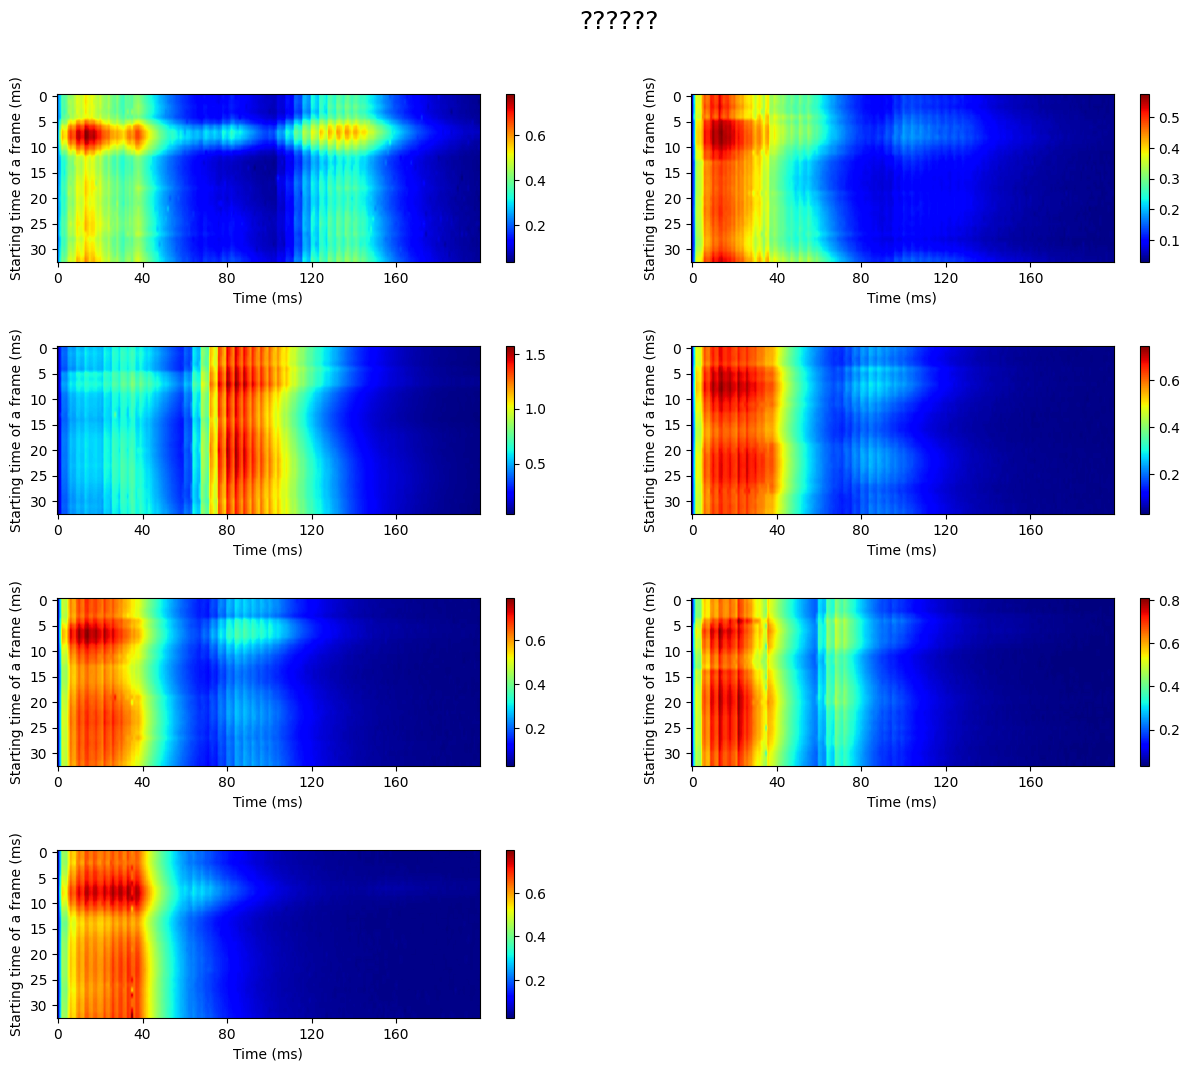

In [531]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("??????", fontsize=18, y=0.95)

# Loop through each cuff_df in the list and plot in a 4x4 grid
for n, cuff_df in enumerate(cuff_df_reshaped_by_burst):
    ax_subp = plt.subplot(4, 2, n + 1)  # 4x4 grid, current plot position is n+1

    im1 = ax_subp.imshow(cuff_df, aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)
    
    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(x_ticks)
    ax_subp.set_yticks(y_ticks)
    ax_subp.set_xlabel("Time (ms)")
    ax_subp.set_ylabel("Starting time of a frame (ms)")

plt.show()

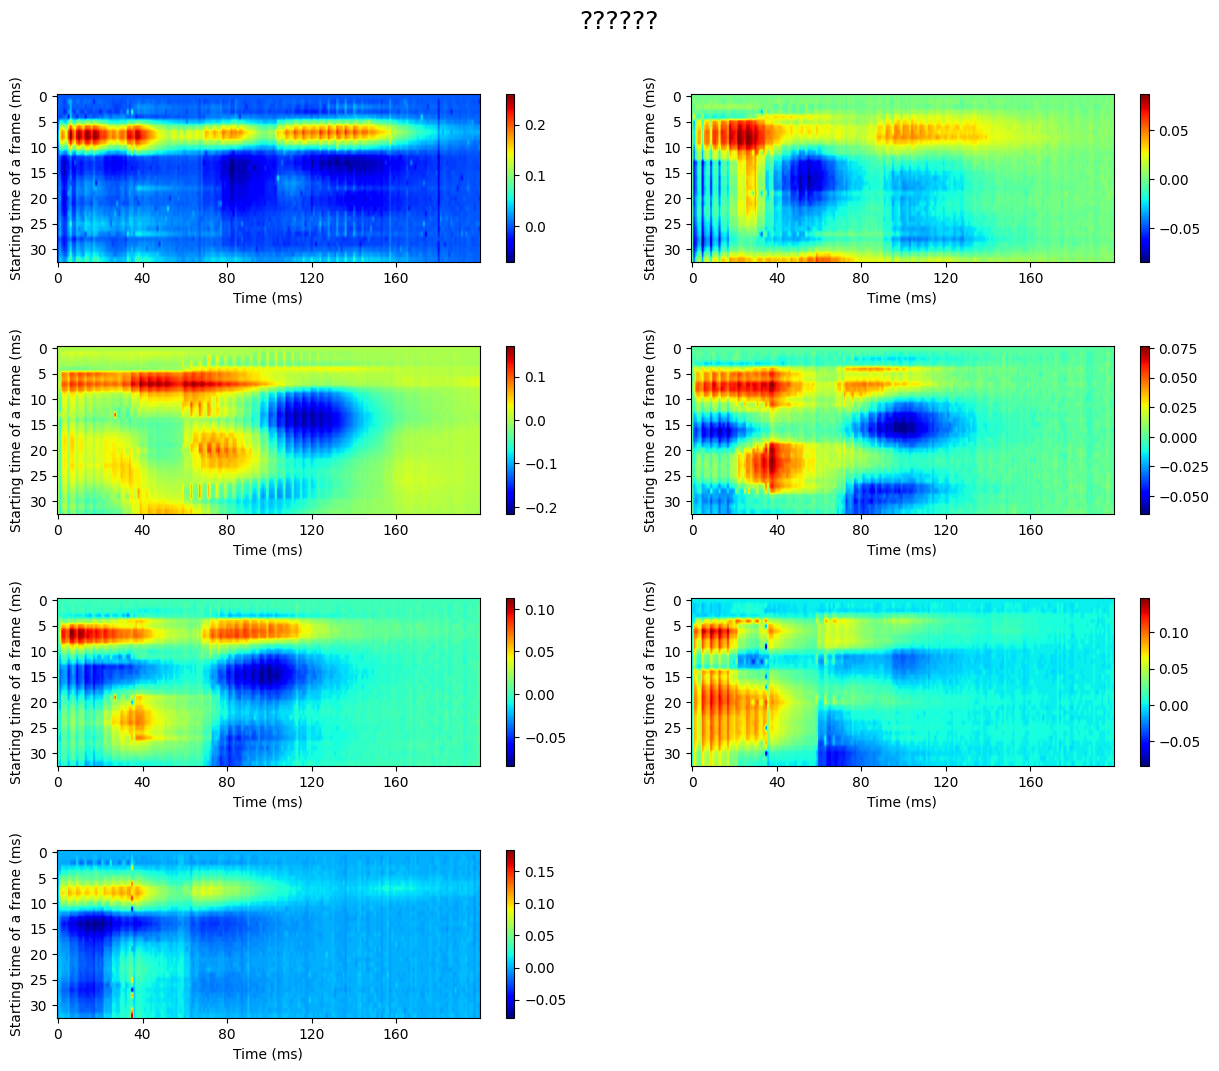

In [532]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("??????", fontsize=18, y=0.95)

# Loop through each cuff_df in the list and plot in a 4x4 grid
for n, cuff_df in enumerate(cuff_df_reshaped_by_burst):
    ax_subp = plt.subplot(4, 2, n + 1)  # 4x4 grid, current plot position is n+1

    im1 = ax_subp.imshow(cuff_df - cuff_df[0, :], aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)
    
    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(x_ticks)
    ax_subp.set_yticks(y_ticks)
    ax_subp.set_xlabel("Time (ms)")
    ax_subp.set_ylabel("Starting time of a frame (ms)")

plt.show()

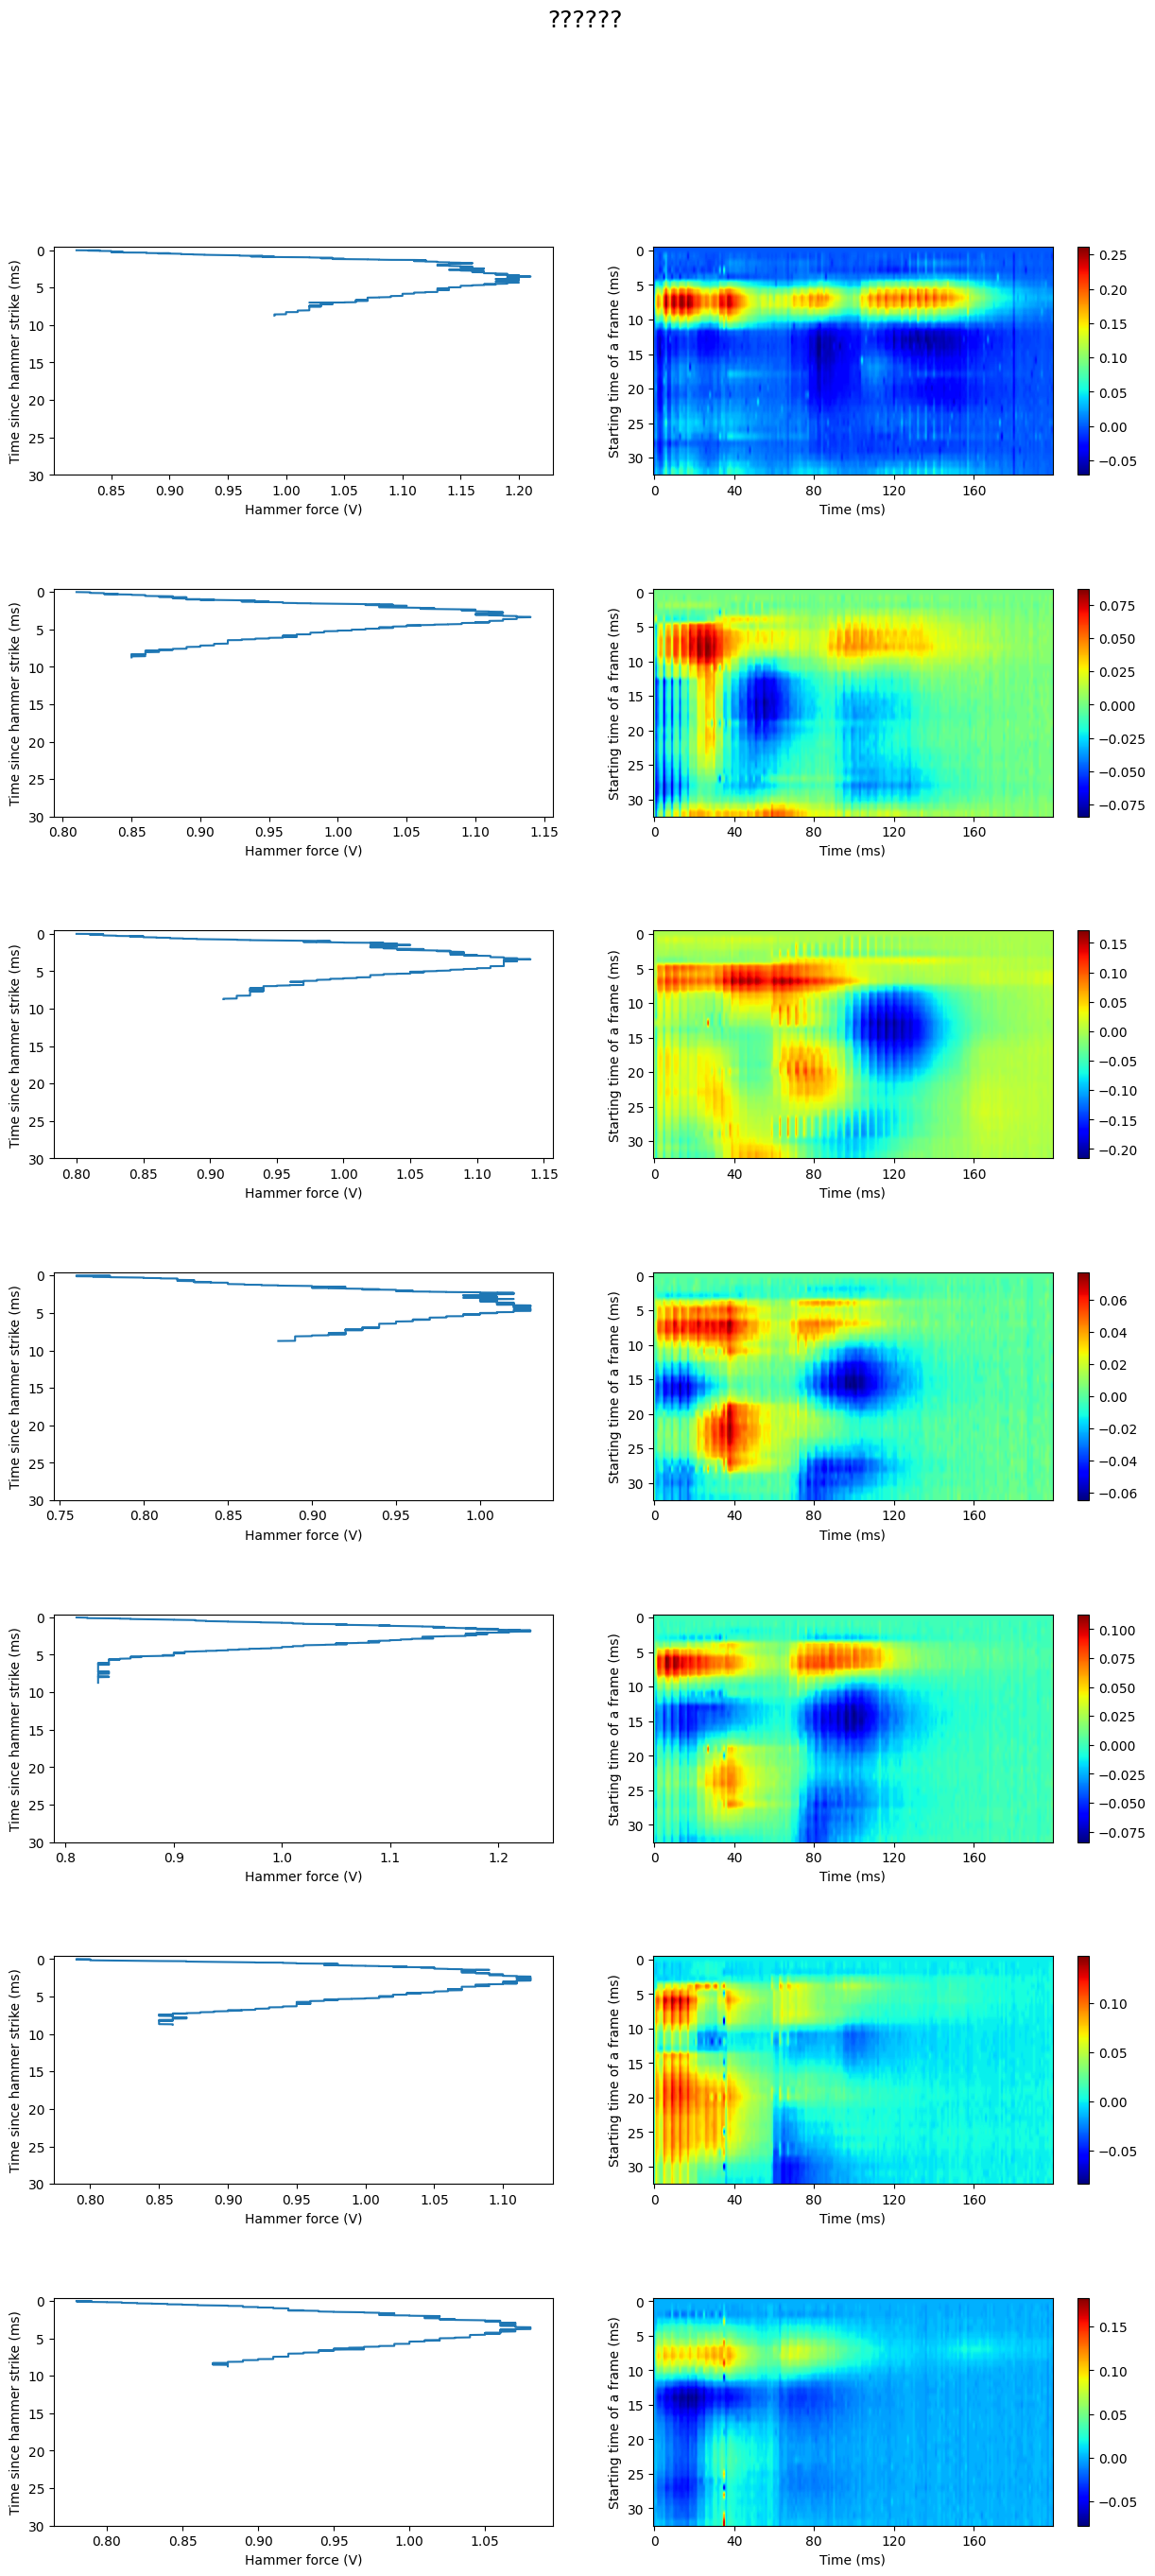

In [545]:
plt.figure(figsize=(15, 36))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("??????", fontsize=18, y=0.95)

# Loop through each cuff_df in the list and plot in a 4x4 grid
for n in range(len(cuff_df_reshaped_by_burst)):
    cuff_df = cuff_df_reshaped_by_burst[n]
    hammer_df = hammer_dfs[n]
    
    ax_subp_hammer = plt.subplot(8, 2, 2*n+1)
    ax_subp_hammer.plot(hammer_df[:,1], hammer_df[:,0]) 
    ax_subp_hammer.set_xlabel("Hammer force (V)")
    ax_subp_hammer.set_ylabel("Time since hammer strike (ms)")
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp_hammer.set_yticks(y_ticks)
    ax_subp_hammer.set_ylim(ax_subp_hammer.get_ylim()[::-1])    # have to flip upside down some reason?
    
    ax_subp = plt.subplot(8, 2, 2*n + 2)  # 4x4 grid, current plot position is n+1
    im1 = ax_subp.imshow(cuff_df - cuff_df[0, :], aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)

    x_ticks = np.arange(0, DATA_LENGTH, 40)
    y_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp.set_xticks(x_ticks)
    ax_subp.set_yticks(y_ticks)
    ax_subp.set_xlabel("Time (ms)")
    ax_subp.set_ylabel("Starting time of a frame (ms)")

plt.show()

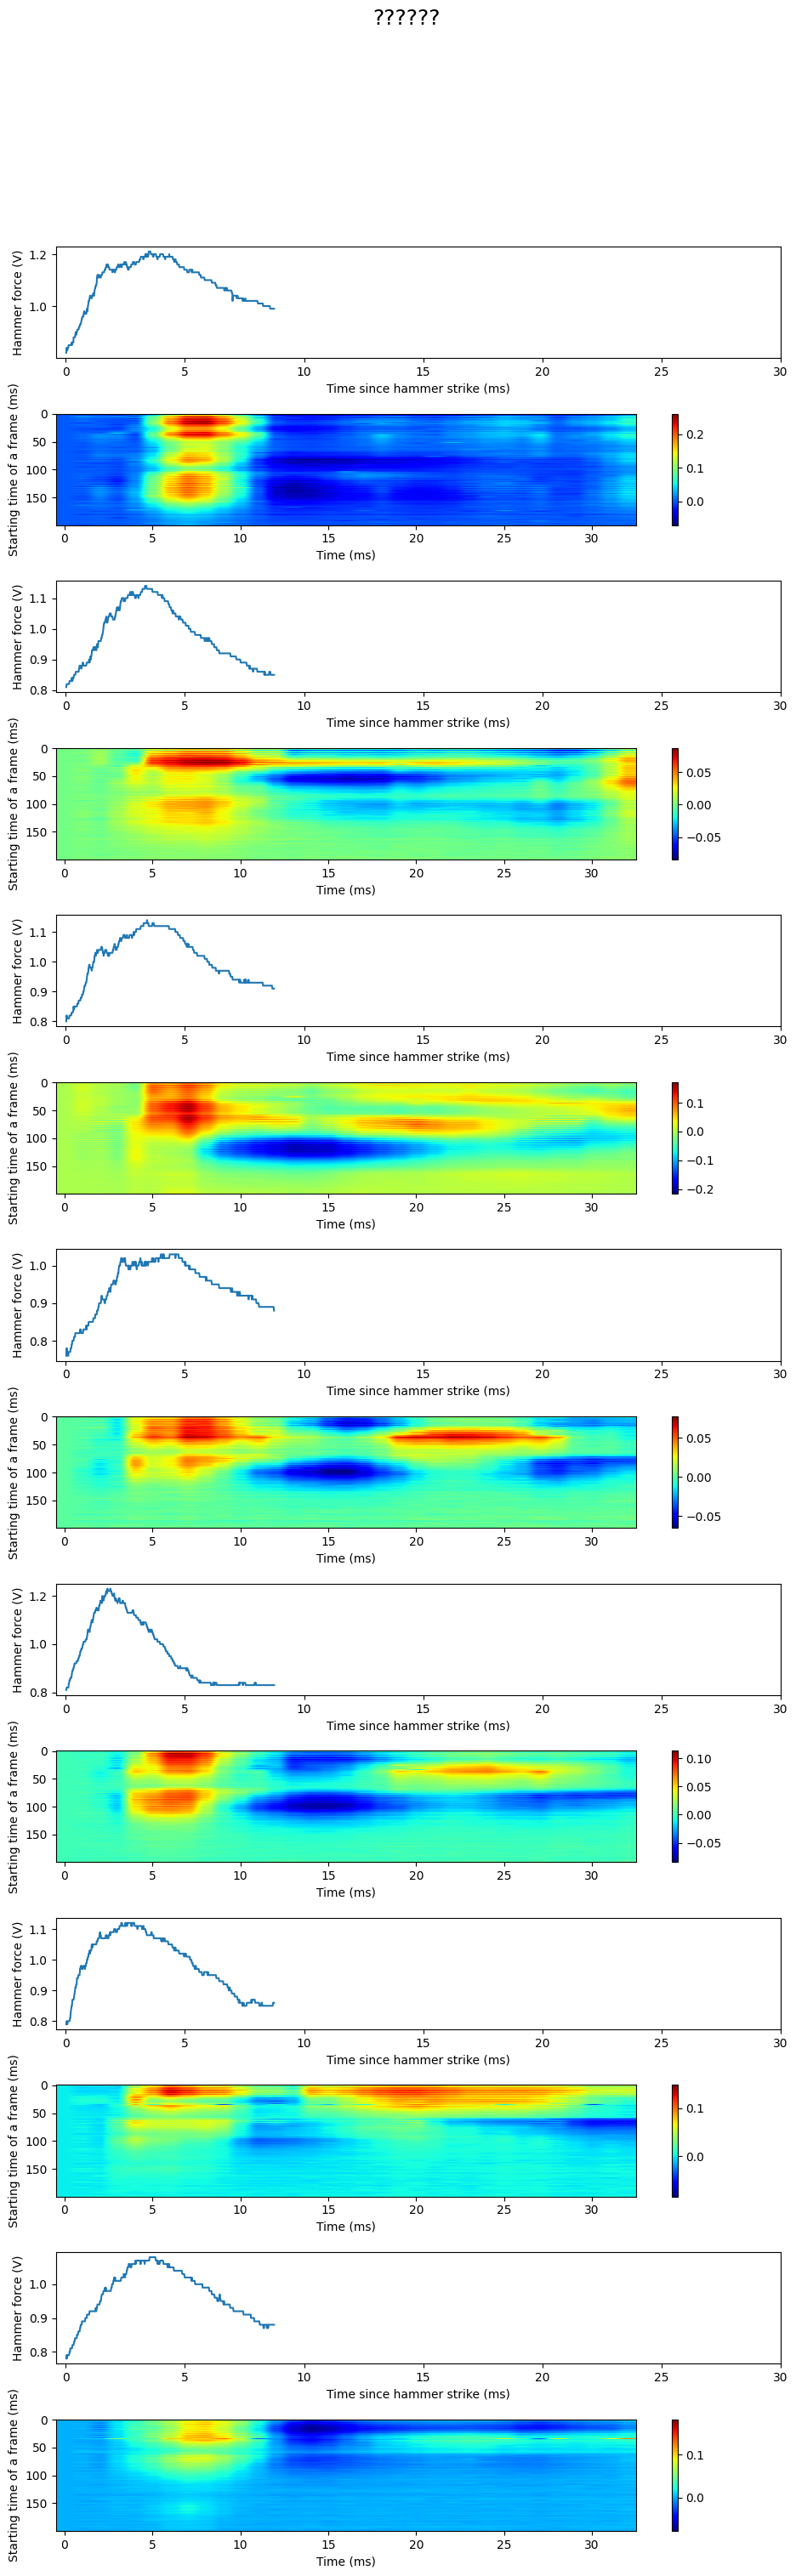

In [566]:
plt.figure(figsize=(11, 40))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("??????", fontsize=18, y=0.95)

# Loop through each cuff_df in the list and plot in a 4x4 grid
for n in range(len(cuff_df_reshaped_by_burst)):
    cuff_df = cuff_df_reshaped_by_burst[n]
    hammer_df = hammer_dfs[n]
    
    ax_subp_hammer = plt.subplot(16, 1, 2*n+1)
    ax_subp_hammer.plot(hammer_df[:,0], hammer_df[:,1]) 
    ax_subp_hammer.set_ylabel("Hammer force (V)")
    ax_subp_hammer.set_xlabel("Time since hammer strike (ms)")
    x_ticks = np.arange(0, NUM_PULSES, 5)
    ax_subp_hammer.set_xticks(x_ticks)
    
    ax_subp = plt.subplot(16, 1, 2*n + 2)  # 4x4 grid, current plot position is n+1
    im1 = ax_subp.imshow(np.transpose(cuff_df - cuff_df[0, :]), aspect='auto', cmap='jet')
    plt.colorbar(im1, ax=ax_subp)

    ax_subp.set_xlabel("Time (ms)")
    ax_subp.set_ylabel("Starting time of a frame (ms)")

plt.show()